## First preparing (ash-color) data for all timesteps and loading pretrained UNET 

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


PATH = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/"

class ContrailsDataset(Dataset):
    def __init__(self, split="train", mode="single"):
        self.split = split
        self.mode = mode
        self.path = f'{PATH}{split}/'
        self.examples = os.listdir(self.path)
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:

            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)

        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        if self.mode == "single":
            return false_color[..., 4]
        else:
            return false_color
    
    def __getitem__(self, index):
        path = f"{self.path}{self.examples[index]}"
        data = self.read_record(path)    
        
        img = self.get_false_color(data)
        
        if self.mode == "single":
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1).squeeze()
        else:
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1)
        
        img = self.normalize_image(img)
        
        if self.split in ["train", "validation"]:
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
            return img.float(), label
        
        return img.float()
    
    def __len__(self):
        return len(self.examples)

In [2]:
import sys
sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master")
sys.path.append("/kaggle/input/pretrained-models-pytorch")
sys.path.append("/kaggle/input/efficientnet-pytorch")

In [3]:
train_ds_multi = ContrailsDataset("train", "multi")
val_ds_multi = ContrailsDataset("validation", "multi")

Data: Timestep x Channel x Width x Height

In [4]:
train_ds_multi[0][0].shape

torch.Size([8, 3, 256, 256])

Label: Width x Height

In [5]:
train_ds_multi[0][1].shape

torch.Size([256, 256])

Copy from smp config:

In [6]:
# config
config = {
    "data_path": "/kaggle/input/contrails-images-ash-color",
    "model": {
        "encoder_name": "timm-efficientnet-b3",
        "loss_smooth": 1.0,
        "optimizer_params": {"lr": 0.003, "weight_decay": 0.01},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 500, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.31622776601,
                    "mode": "min",
                    "patience": 4,
                    "verbose": True,
                },
            },
        },
        "seg_model": "Unet++",
    },
    "output_dir": "models",
    "progress_bar_refresh_rate": 50,
    "seed": 42,
    "train_bs": 32,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 30,
        "min_epochs": 30,
    },
    "valid_bs": 64,
    "workers": 2,
}

Datasource for checkpoint:

In [7]:
chkpt_path = "/kaggle/input/gr-icrgw-unet-efficientnet-ckpt/model.ckpt"

In [8]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}

class LitModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = seg_models[config["model"]["seg_model"]](
            encoder_name=config["model"]["encoder_name"],
            encoder_weights=None,
            in_channels=3,
            classes=1,
            activation=None,
        )

    def forward(self, batch):
        return self.model(batch)

model = LitModel().load_from_checkpoint(chkpt_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
model.zero_grad()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [9]:
for i in range(10):
    images, label = train_ds_multi[i]
    path = train_ds_multi.examples[i]
    print(f"{path}: {images.shape}, {label.shape}")

1284412112608546821: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
7457695218848685981: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
836236084461732921: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
7829917977180135058: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
5319255125658459358: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
5747024955383921098: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
432548070956515051: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
6249676276128358850: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
6404414125815253353: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])
3120044272041019435: torch.Size([8, 3, 256, 256]), torch.Size([256, 256])


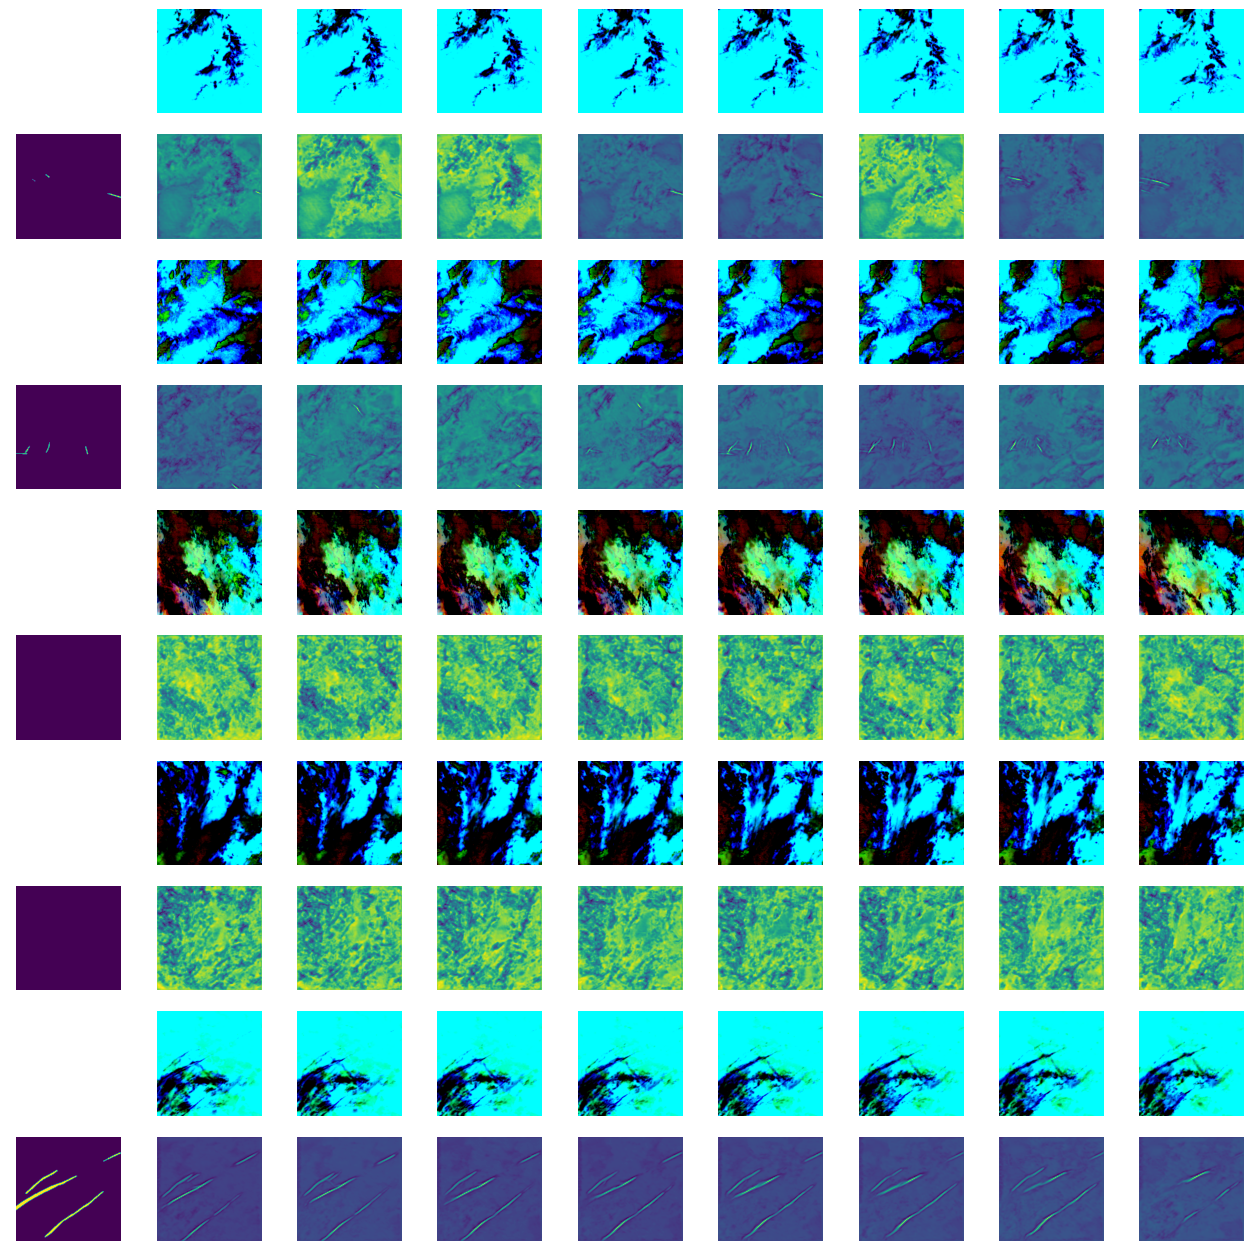

In [10]:
import matplotlib.pyplot as plt

examples_to_check = [100, 80, 64, 42, 3]

nrows, ncols = (len(examples_to_check)*2,9)

fig, axs = plt.subplots(nrows, ncols, figsize = (16,16))

for i, img in enumerate(examples_to_check):
    label = train_ds_multi[img][1]
    preds = model(train_ds_multi[img][0].to(device))
    
    axs[2*i, 0].axis('off')
    
    for j in range(8):
        subimg = train_ds_multi[img][0][j].to("cpu")
        axs[2*i,j+1].imshow(subimg.to("cpu").detach().squeeze().permute(1,2,0))
        axs[2*i,j+1].axis('off')
    
    axs[2*i+1, 0].imshow(label)
    axs[2*i+1, 0].axis('off')
    
    for j in range(8):
        axs[2*i+1, j+1].imshow(preds[j].to("cpu").detach().squeeze())
        axs[2*i+1, j+1].axis('off')
        
plt.show()

del preds

### Do the predictions for all timesteps and save them

In [11]:
out_dir = "/kaggle/working/train"
!mkdir -p $out_dir


for i, (img, _) in enumerate(train_ds_multi):
    if i % 250 == 0:
        print(f"Example {i}")

    name = train_ds_multi.examples[i]
    preds = model(img.to(device))
    preds = preds.to("cpu").detach().squeeze()
    preds = np.float16(preds)
    np.savez_compressed(f"{out_dir}/{name}.npz", preds)

Example 0
Example 250
Example 500
Example 750
Example 1000
Example 1250
Example 1500
Example 1750
Example 2000
Example 2250
Example 2500
Example 2750
Example 3000
Example 3250
Example 3500
Example 3750
Example 4000
Example 4250
Example 4500
Example 4750
Example 5000
Example 5250
Example 5500
Example 5750
Example 6000
Example 6250
Example 6500
Example 6750
Example 7000
Example 7250
Example 7500
Example 7750
Example 8000
Example 8250
Example 8500
Example 8750
Example 9000
Example 9250
Example 9500
Example 9750
Example 10000
Example 10250
Example 10500
Example 10750
Example 11000
Example 11250
Example 11500
Example 11750
Example 12000
Example 12250
Example 12500
Example 12750
Example 13000
Example 13250
Example 13500
Example 13750
Example 14000
Example 14250
Example 14500
Example 14750
Example 15000
Example 15250
Example 15500
Example 15750
Example 16000
Example 16250
Example 16500
Example 16750
Example 17000
Example 17250
Example 17500
Example 17750
Example 18000
Example 18250
Example 18

In [12]:
train_examples = os.listdir("/kaggle/working/train")
print(train_examples[0])

3986871856300287465.npz


In [13]:
out_dir = "/kaggle/working/validation"
!mkdir -p $out_dir

for i, (img, _) in enumerate(val_ds_multi):
    if i % 250 == 0:
        print(f"Example {i}")
    name = val_ds_multi.examples[i]
    preds = model(img.to(device))
    preds = preds.to("cpu").detach().squeeze()
    preds = np.float16(preds)
    np.savez_compressed(f"{out_dir}/{name}.npz", preds)

Example 0
Example 250
Example 500
Example 750
Example 1000
Example 1250
Example 1500
Example 1750


### Calcuating Mean and SD to normalize the data before feeding into the next-stage UNET

In [18]:
means=[]
sds=[]
for i in range(200,500):
    
    pred1 = np.load("/kaggle/working/train/" + train_examples[i])["arr_0"]
    means.append(np.array(pred1, dtype=np.float64).flatten().mean())
    sds.append(np.array(pred1, dtype=np.float64).flatten().std())
print(np.mean(means))
print(np.mean(sds)) 

MEAN = np.mean(means)
SD = np.mean(sds) + np.std(sds)

-40.703120117591084
14.756059170480349


## Setting up the Dataloader for training step 2

In [19]:
class ContrailPredDataset(torch.utils.data.Dataset):
    def __init__(self, stage= "train", timesteps=range(0,8)):
        self.path_to_img = "/kaggle/working/" + stage + "/"
        self.stage = stage
        self.path_to_label = os.path.join("/kaggle/input/google-research-identify-contrails-reduce-global-warming/", self.stage)
        self.examples = os.listdir(self.path_to_img)
        self.timesteps = timesteps
        self.nb_timesteps = len(timesteps)
        self.normalize_image = T.Normalize(np.repeat(MEAN, self.nb_timesteps), np.repeat(SD, self.nb_timesteps))

    def __getitem__(self, index):
        example = self.examples[index].replace(".npz", "")
        img = np.load(os.path.join(self.path_to_img, self.examples[index]), allow_pickle=True)["arr_0"]
        img = torch.tensor(img[self.timesteps,:,:], dtype=torch.float32)

        label = torch.tensor(np.load(os.path.join(self.path_to_label, example) + "/human_pixel_masks.npy"), dtype=torch.float32)

        img = self.normalize_image(img)

        return img, label

    def __len__(self):
        return len(self.examples)

In [20]:
files=os.listdir("/kaggle/working/train/")
files[0].replace(".npz", "")

'3986871856300287465'

In [22]:
# config
config2 = {
    "model": {
        "encoder_name": "timm-resnest26d",
        "encoder_weights": None, #"imagenet"
        "loss_smooth": 1.0,
        "optimizer_params": {"lr": 0.005, "weight_decay": 0.01},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 500, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.31622776601,
                    "mode": "min",
                    "patience": 4,
                    "verbose": True,
                },
            },
        },
        "seg_model": "Unet++",
    },
    "output_dir": "models",
    "progress_bar_refresh_rate": 50,
    "seed": 531,
    "train_bs": 32,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 15,
        "min_epochs": 15,
    },
    "valid_bs": 64,
    "workers": 2,
}

In [23]:
# Lightning module

class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = seg_models[self.config["model"]["seg_model"]](
            encoder_name=self.config["model"]["encoder_name"],
            encoder_weights=self.config["model"]["encoder_weights"],
            in_channels=8,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=self.config["model"]["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["model"]["optimizer_params"])

        if self.config["model"]["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["model"]["scheduler"]["params"][self.config["model"]["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["model"]["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["model"]["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)

In [24]:
dataset_train = ContrailPredDataset(stage= "train",timesteps=range(2,6))
dataset_validation = ContrailPredDataset(stage= "validation",timesteps=range(2,6))

data_loader_train = DataLoader(
    dataset_train, batch_size=config["train_bs"], shuffle=True , num_workers=config["workers"]
)
data_loader_validation = DataLoader(
    dataset_validation, batch_size=config["valid_bs"], shuffle=False , num_workers=config["workers"]
)


In [ ]:
# load one batch of images and labels
dataiter = iter(data_loader_train)
images, targets = next(dataiter)

# check shapes of the batch
images = torch.tensor(images)
print(images.shape)

In [ ]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/timm-pretrained-resnest/resnest/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.optim import AdamW
from torchmetrics.functional import dice
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from pytorch_lightning.loggers import CSVLogger

dataset_train = ContrailPredDataset(stage= "train")
dataset_validation = ContrailPredDataset(stage= "validation")

data_loader_train = DataLoader(
    dataset_train, batch_size=config["train_bs"], shuffle=True, num_workers=config["workers"]
)
data_loader_validation = DataLoader(
    dataset_validation, batch_size=config["valid_bs"], shuffle=False, num_workers=config["workers"]
)

pl.seed_everything(config["seed"])

filename = f"model"

# Instantiate CSV logger
csv_logger = CSVLogger('logs/', name='csv_log')

checkpoint_callback = ModelCheckpoint(
    monitor="val_dice",
    dirpath=config["output_dir"],
    mode="max",
    filename=filename,
    save_top_k=1,
    verbose=1,
)

progress_bar_callback = TQDMProgressBar(refresh_rate=config["progress_bar_refresh_rate"])

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback],
    logger=csv_logger, 
    **config["trainer"],
)

model = LightningModule(config2)

## Training

In [26]:
trainer.fit(model, data_loader_train, data_loader_validation)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Plotting Training Predictions/Performance after stage 2

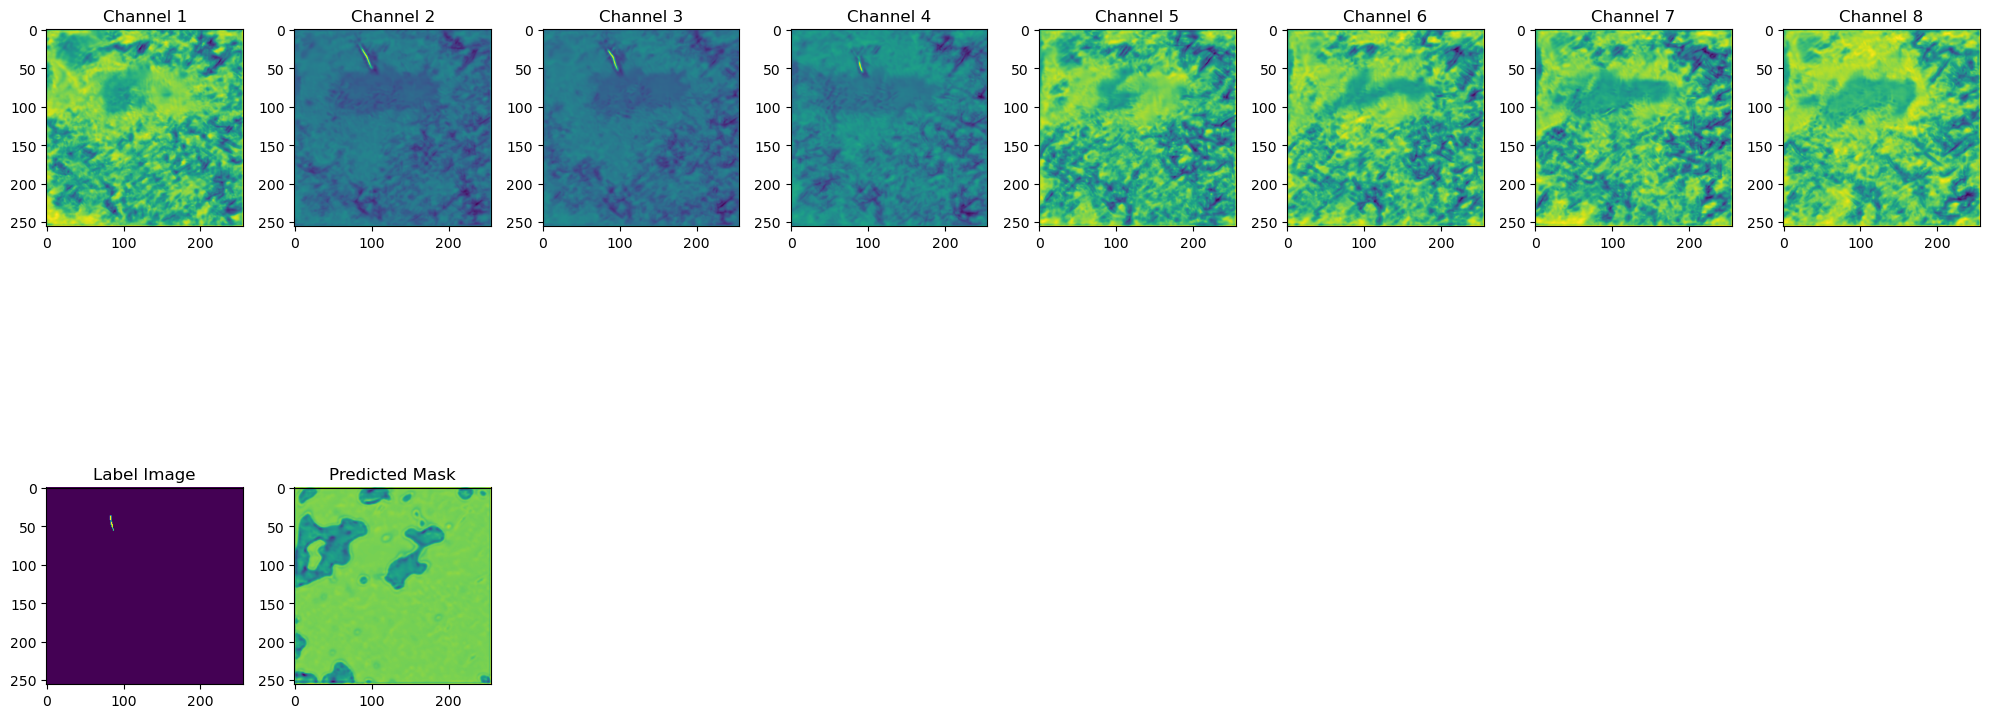

In [69]:
# Make sure the model is in evaluation mode
model.eval()

# Get the first batch of the validation set
inputs, labels = next(valdata)

# Move to the same device as your model if necessary
inputs = inputs.to(device)
labels = labels.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(inputs)

# Apply the sigmoid function to get probabilities
outputs = outputs.data.cpu().numpy()
labels = labels.data.cpu().numpy()

# Select the first example from the batch
# Add more indices if batch size > 1
inputs = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0))  # moving channels to last dimension
true_mask = np.squeeze(labels[0])
pred_mask = np.squeeze(outputs[0])

# Create figure
fig = plt.figure(figsize=(20, 10))

# Loop through each channel in the input image
for i in range(inputs.shape[2]):
    ax = fig.add_subplot(2, inputs.shape[2], i+1)
    ax.imshow(inputs[:, :, i], cmap='viridis')
    ax.set_title(f'Channel {i + 1}')

# Display the true and predicted masks
ax_true_mask = fig.add_subplot(2, inputs.shape[2], inputs.shape[2] + 1)
ax_true_mask.imshow(true_mask, cmap='viridis')
ax_true_mask.set_title('Label Image')

ax_pred_mask = fig.add_subplot(2, inputs.shape[2], inputs.shape[2] + 2)
ax_pred_mask.imshow(pred_mask, cmap='viridis')
ax_pred_mask.set_title('Predicted Mask')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
# load the csv file
log_data = pd.read_csv("logs/csv_log/version_0/metrics.csv")

log_data.columns

In [ ]:
# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(log_data['step'], log_data['train_loss_step'], label='Training Loss')
#plt.plot(log_data['step'], log_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(log_data['epoch'][log_data['val_dice'].notna()], log_data['val_loss'][log_data['val_dice'].notna()], label='Val Loss')
#plt.plot(log_data['step'], log_data['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(log_data['epoch'][log_data['val_dice'].notna()], log_data['val_dice'][log_data['val_dice'].notna()], label='Val Loss')
#plt.plot(log_data['step'], log_data['val_loss'], label='Validation Loss')
plt.title('Dice Score Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()